[*********************100%%**********************]  1 of 1 completed


RandomForest: MSE = 4.484608206456306, MAE = 1.3138895296111075
GradientBoosting: MSE = 4.54956209509164, MAE = 1.332471016860375
XGBoost: MSE = 4.548440765350806, MAE = 1.3331179855649937
SVR: MSE = 5.287917553947917, MAE = 1.52445669333938


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
LSTM: MSE = 1.2882743354185862, MAE = 0.5372191457448136
Best model: LSTM with MSE = 1.2882743354185862


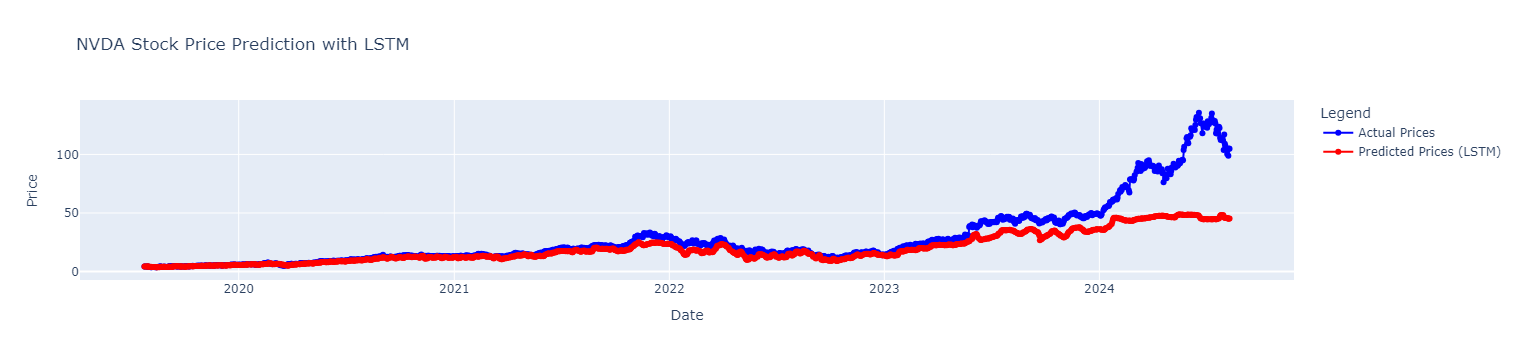

Final Mean Squared Error (Best Model: LSTM): 352.6002799428781
Final Mean Absolute Error (Best Model: LSTM): 8.887684529223018


In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import plotly.graph_objs as go

#  Yahoo Finance data
ticker = "NVDA"
df = yf.download(ticker)

# Features
df['MA_10'] = df['Adj Close'].rolling(window=10).mean()
df['MA_50'] = df['Adj Close'].rolling(window=50).mean()
df['RSI'] = (100 - (100 / (1 + df['Adj Close'].pct_change().rolling(window=14).mean() / df['Adj Close'].pct_change().rolling(window=14).std()))).fillna(50)
df['Upper_BB'] = df['MA_10'] + 2*df['Adj Close'].rolling(window=10).std()
df['Lower_BB'] = df['MA_10'] - 2*df['Adj Close'].rolling(window=10).std()
df['MACD'] = df['Adj Close'].ewm(span=12, adjust=False).mean() - df['Adj Close'].ewm(span=26, adjust=False).mean()
df['Volume'] = df['Volume']

# Lag features
df['Lag_1'] = df['Adj Close'].shift(1)
df['Lag_2'] = df['Adj Close'].shift(2)
df['Lag_3'] = df['Adj Close'].shift(3)

# Drop NaN 
df = df.dropna()

# Scaling features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Adj Close', 'MA_10', 'MA_50', 'RSI', 'Upper_BB', 'Lower_BB', 'MACD', 'Volume', 'Lag_1', 'Lag_2', 'Lag_3']])

#  training/testing
X = []
Y = []
forecast_out = 30

for i in range(forecast_out, len(scaled_data)):
    X.append(scaled_data[i-forecast_out:i])
    Y.append(scaled_data[i, 0])  # Predicting 'Adj Close'

X = np.array(X)
Y = np.array(Y)

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)


X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

#  models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100),
    "XGBoost": XGBRegressor(n_estimators=100),
    "SVR": SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
}

# Evaluate 
model_results = {}

for name, model in models.items():
    model.fit(X_train_flat, Y_train)
    predictions = model.predict(X_test_flat)
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    model_results[name] = {"mse": mse, "mae": mae}
    print(f"{name}: MSE = {mse}, MAE = {mae}")

#  LSTM  
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=0)

lstm_predictions = lstm_model.predict(X_test).flatten()
lstm_mse = mean_squared_error(Y_test, lstm_predictions)
lstm_mae = mean_absolute_error(Y_test, lstm_predictions)
model_results["LSTM"] = {"mse": lstm_mse, "mae": lstm_mae}
print(f"LSTM: MSE = {lstm_mse}, MAE = {lstm_mae}")

#  best model based on MSE
best_model_name = min(model_results, key=lambda k: model_results[k]["mse"])
best_model_mse = model_results[best_model_name]["mse"]

print(f"Best model: {best_model_name} with MSE = {best_model_mse}")

#  predictions
if best_model_name == "LSTM":
    best_predictions = lstm_predictions
else:
    best_model = models[best_model_name]
    best_predictions = best_model.predict(X_test_flat)

best_predictions = scaler.inverse_transform(np.concatenate((best_predictions.reshape(-1, 1), np.zeros((best_predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# Actual prices
actual_prices = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

#  plot 
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index[-len(actual_prices):], y=actual_prices, mode='lines+markers', name='Actual Prices', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df.index[-len(actual_prices):], y=best_predictions, mode='lines+markers', name=f'Predicted Prices ({best_model_name})', line=dict(color='red')))

fig.update_layout(
    title=f"{ticker} Stock Price Prediction with {best_model_name}",
    xaxis_title="Date",
    yaxis_title="Price",
    legend_title="Legend",
    hovermode="x unified"
)


fig.show()

# Final evaluation
final_mse = mean_squared_error(actual_prices, best_predictions)
final_mae = mean_absolute_error(actual_prices, best_predictions)
print(f'Final Mean Squared Error (Best Model: {best_model_name}): {final_mse}')
print(f'Final Mean Absolute Error (Best Model: {best_model_name}): {final_mae}')
